# 9 WorkFlow Analista Jr

## 9.1 Objetivo

Presentar un workflow/pipeline completo al que los estudiantes deberán
<br>El Analista Jr corre sus scripts en la virtual manchine **desktop-jr** que tiene estas características


*   Normal, paga tarifa completa, nunca es apagada por Google
*   reside en el datacenter de Sao Paulo, Brasil
*   64 GB de memoria RAM
*   8 vCPU



## 9.3  Workflow

## Inicializacion

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [1]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "sá. nov. 15 18:22:50 2025"

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657643,35.2,1446461,77.3,1352314,72.3
Vcells,1212529,9.3,8388608,64.0,1929748,14.8


In [3]:
require("data.table")

if( !require("R.utils")) install.packages("R.utils")
require("R.utils")

Cargando paquete requerido: data.table

Cargando paquete requerido: R.utils

Warning message:
"package 'R.utils' was built under R version 4.5.1"
Cargando paquete requerido: R.oo

Cargando paquete requerido: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Adjuntando el paquete: 'R.oo'


The following object is masked from 'package:R.methodsS3':

    throw


The following objects are masked from 'package:methods':

    getClasses, getMethods


The following objects are masked from 'package:base':

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Adjuntando el paquete: 'R.utils'


The following object is masked from 'package:utils':

    timestamp


The following objects are masked from 'package:base':

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings




#### Parametros

In [4]:
PARAM <- list()
PARAM$semilla_primigenia <- 10083

PARAM$experimento <- 9102
PARAM$dataset <- "analistajr_competencia_2025.csv.gz"

#### Carpeta del Experimento

In [5]:

getwd()

[1] "d:/MCD/b1/repos/labo2025v/src/workflows"

In [6]:
# carpeta de trabajo

setwd("../../../../exp")
experimento_folder <- paste0("WF", PARAM$experimento)

ruta_exp <- file.path("./", experimento_folder)

dir.create(experimento_folder, showWarnings=FALSE)
setwd(ruta_exp)

getwd()

[1] "d:/MCD/b1/exp/WF9102"

### 9.3.1   Preprocesamiento del dataset

#### 9.3.1.1  DT incorporar dataset

In [7]:
# lectura del dataset
dataset <- fread(paste0("../../../b1/datasets/", PARAM$dataset))

#### 9.3.1.2  CA  Catastrophe Analysis
Se intentan reparar las variables que para un mes están con todos los valores en cero.

El método que se utiliza es **Machine Learning** se asigna NA also valores, si ha leido bien, es la "anti imputación de valores faltantes"
<br> Usted podrá aplicar aquí otros métodos

In [8]:
if( !require("mice")) install.packages("mice", repos = "http://cran.us.r-project.org")
require("mice")

Cargando paquete requerido: mice

Warning message:
"package 'mice' was built under R version 4.5.2"

Adjuntando el paquete: 'mice'


The following object is masked from 'package:stats':

    filter


The following objects are masked from 'package:base':

    cbind, rbind




In [9]:
# Escrito por alumnos de  Universidad Austral  Rosario

Corregir_MICE <- function(pcampo, pmeses) {

  meth <- rep("", ncol(dataset))
  names(meth) <- colnames(dataset)
  meth[names(meth) == pcampo] <- "sample"

  # llamada a mice  !
  imputacion <- mice(dataset,
    method = meth,
    maxit = 5,
    m = 1,
    seed = 7)

  tbl <- mice::complete(dataset)

  dataset[, paste0(pcampo) := ifelse(foto_mes %in% pmeses, tbl[, get(pcampo)], get(pcampo))]

}


In [10]:
Corregir_interpolar <- function(pcampo, pmeses) {

  tbl <- dataset[, list(
    "v1" = shift(get(pcampo), 1, type = "lag"),
    "v2" = shift(get(pcampo), 1, type = "lead")
  ),
  by = eval(envg$PARAM$dataset_metadata$entity_id)
  ]

  tbl[, paste0(envg$PARAM$dataset_metadata$entity_id) := NULL]
  tbl[, promedio := rowMeans(tbl, na.rm = TRUE)]

  dataset[
    ,
    paste0(pcampo) := ifelse(!(foto_mes %in% pmeses),
      get(pcampo),
      tbl$promedio
    )
  ]
}

In [11]:
AsignarNA_campomeses <- function(pcampo, pmeses) {

  if( pcampo %in% colnames( dataset ) ) {

    dataset[ foto_mes %in% pmeses, paste0(pcampo) := NA ]
  }
}

In [12]:

Corregir_atributo <- function(pcampo, pmeses, pmetodo)
{
  # si el campo no existe en el dataset, Afuera !
  if( !(pcampo %in% colnames( dataset )) )
    return( 1 )

  # llamo a la funcion especializada que corresponde
  switch( pmetodo,
    "MachineLearning"     = AsignarNA_campomeses(pcampo, pmeses),
    "EstadisticaClasica"  = Corregir_interpolar(pcampo, pmeses),
    "MICE"                = Corregir_MICE(pcampo, pmeses),
  )

  return( 0 )
}

In [13]:

Corregir_Rotas <- function(dataset, pmetodo) {
  gc(verbose= FALSE)
  cat( "inicio Corregir_Rotas()\n")
  # acomodo los errores del dataset

  Corregir_atributo("active_quarter", c(202006), pmetodo) # 1
  Corregir_atributo("internet", c(202006), pmetodo) # 2

  Corregir_atributo("mrentabilidad", c(201905, 201910, 202006), pmetodo) # 3
  Corregir_atributo("mrentabilidad_annual", c(201905, 201910, 202006), pmetodo) # 4

  Corregir_atributo("mcomisiones", c(201905, 201910, 202006), pmetodo) # 5

  Corregir_atributo("mactivos_margen", c(201905, 201910, 202006), pmetodo) # 6
  Corregir_atributo("mpasivos_margen", c(201905, 201910, 202006), pmetodo) # 7

  Corregir_atributo("mcuentas_saldo", c(202006), pmetodo) # 8

  Corregir_atributo("ctarjeta_debito_transacciones", c(202006), pmetodo) # 9

  Corregir_atributo("mautoservicio", c(202006), pmetodo) # 10

  Corregir_atributo("ctarjeta_visa_transacciones", c(202006), pmetodo) # 11
  Corregir_atributo("mtarjeta_visa_consumo", c(202006), pmetodo) # 12

  Corregir_atributo("ctarjeta_master_transacciones", c(202006), pmetodo) # 13
  Corregir_atributo("mtarjeta_master_consumo", c(202006), pmetodo) # 14

  Corregir_atributo("ctarjeta_visa_debitos_automaticos", c(201904), pmetodo) # 15
  Corregir_atributo("mttarjeta_visa_debitos_automaticos", c(201904), pmetodo) # 16

  Corregir_atributo("ccajeros_propios_descuentos",
    c(201910, 202002, 202006, 202009, 202010, 202102), pmetodo) # 17

  Corregir_atributo("mcajeros_propios_descuentos",
    c(201910, 202002, 202006, 202009, 202010, 202102), pmetodo) # 18

  Corregir_atributo("ctarjeta_visa_descuentos",
    c(201910, 202002, 202006, 202009, 202010, 202102), pmetodo) # 19

  Corregir_atributo("mtarjeta_visa_descuentos",
    c(201910, 202002, 202006, 202009, 202010, 202102), pmetodo) # 20

  Corregir_atributo("ctarjeta_master_descuentos",
    c(201910, 202002, 202006, 202009, 202010, 202102), pmetodo) # 21

  Corregir_atributo("mtarjeta_master_descuentos",
    c(201910, 202002, 202006, 202009, 202010, 202102), pmetodo) # 22

  Corregir_atributo("ccomisiones_otras", c(201905, 201910, 202006), pmetodo) # 23
  Corregir_atributo("mcomisiones_otras", c(201905, 201910, 202006), pmetodo) # 24

  Corregir_atributo("cextraccion_autoservicio", c(202006), pmetodo) # 25
  Corregir_atributo("mextraccion_autoservicio", c(202006), pmetodo) # 26

  Corregir_atributo("ccheques_depositados", c(202006), pmetodo) # 27
  Corregir_atributo("mcheques_depositados", c(202006), pmetodo) # 28
  Corregir_atributo("ccheques_emitidos", c(202006), pmetodo) # 29
  Corregir_atributo("mcheques_emitidos", c(202006), pmetodo) # 30
  Corregir_atributo("ccheques_depositados_rechazados", c(202006), pmetodo) # 31
  Corregir_atributo("mcheques_depositados_rechazados", c(202006), pmetodo) # 32
  Corregir_atributo("ccheques_emitidos_rechazados", c(202006), pmetodo) # 33
  Corregir_atributo("mcheques_emitidos_rechazados", c(202006), pmetodo) # 34

  Corregir_atributo("tcallcenter", c(202006), pmetodo) # 35
  Corregir_atributo("ccallcenter_transacciones", c(202006), pmetodo) # 36

  Corregir_atributo("thomebanking", c(202006), pmetodo) # 37
  Corregir_atributo("chomebanking_transacciones", c(201910, 202006), pmetodo) # 38

  Corregir_atributo("ccajas_transacciones", c(202006), pmetodo) # 39
  Corregir_atributo("ccajas_consultas", c(202006), pmetodo) # 40

  Corregir_atributo("ccajas_depositos", c(202006, 202105), pmetodo) # 41

  Corregir_atributo("ccajas_extracciones", c(202006), pmetodo) # 41
  Corregir_atributo("ccajas_otras", c(202006), pmetodo) # 43

  Corregir_atributo("catm_trx", c(202006), pmetodo) # 44
  Corregir_atributo("matm", c(202006), pmetodo) # 45
  Corregir_atributo("catm_trx_other", c(202006), pmetodo) # 46
  Corregir_atributo("matm_other", c(202006), pmetodo) # 47

  cat( "fin Corregir_rotas()\n")
}


In [14]:
# resuelvo el Catastrophe Analysis

setorder( dataset, numero_de_cliente, foto_mes )

PARAM$CA$metodo= "MachineLearning"

if( PARAM$CA$metodo %in% c("MachineLearning", "EstadisticaClasica", "MICE") )
  Corregir_Rotas(dataset, PARAM$CA$metodo)

inicio Corregir_Rotas()
fin Corregir_rotas()


#### 9.3.1.3  DR  Data Drifting
Se intenta corregir el data drifting, ajustando por algunos indices financieros

In [15]:
# meses que me interesan para el ajuste de variables monetarias
vfoto_mes <- c(
  201901, 201902, 201903, 201904, 201905, 201906,
  201907, 201908, 201909, 201910, 201911, 201912,
  202001, 202002, 202003, 202004, 202005, 202006,
  202007, 202008, 202009, 202010, 202011, 202012,
  202101, 202102, 202103, 202104, 202105, 202106,
  202107, 202108, 202109
)


In [16]:
# los valores que siguen fueron calculados por alumnos

# momento 1.0  31-dic-2020 a las 23:59
vIPC <- c(
  1.9903030878, 1.9174403544, 1.8296186587,
  1.7728862972, 1.7212488323, 1.6776304408,
  1.6431248196, 1.5814483345, 1.4947526791,
  1.4484037589, 1.3913580777, 1.3404220402,
  1.3154288912, 1.2921698342, 1.2472681797,
  1.2300475145, 1.2118694724, 1.1881073259,
  1.1693969743, 1.1375456949, 1.1065619600,
  1.0681100000, 1.0370000000, 1.0000000000,
  0.9680542110, 0.9344152616, 0.8882274350,
  0.8532444140, 0.8251880213, 0.8003763543,
  0.7763107219, 0.7566381305, 0.7289384687
)

vdolar_blue <- c(
   39.045455,  38.402500,  41.639474,
   44.274737,  46.095455,  45.063333,
   43.983333,  54.842857,  61.059524,
   65.545455,  66.750000,  72.368421,
   77.477273,  78.191667,  82.434211,
  101.087500, 126.236842, 125.857143,
  130.782609, 133.400000, 137.954545,
  170.619048, 160.400000, 153.052632,
  157.900000, 149.380952, 143.615385,
  146.250000, 153.550000, 162.000000,
  178.478261, 180.878788, 184.357143
)

vdolar_oficial <- c(
   38.430000,  39.428000,  42.542105,
   44.354211,  46.088636,  44.955000,
   43.751429,  54.650476,  58.790000,
   61.403182,  63.012632,  63.011579,
   62.983636,  63.580556,  65.200000,
   67.872000,  70.047895,  72.520952,
   75.324286,  77.488500,  79.430909,
   83.134762,  85.484737,  88.181667,
   91.474000,  93.997778,  96.635909,
   98.526000,  99.613158, 100.619048,
  101.619048, 102.569048, 103.781818
)

vUVA <- c(
  2.001408838932958,  1.950325472789153,  1.89323032351521,
  1.8247220405493787, 1.746027787673673,  1.6871348409529485,
  1.6361678865622313, 1.5927529755859773, 1.5549162794128493,
  1.4949100586391746, 1.4197729500774545, 1.3678188186372326,
  1.3136508617223726, 1.2690535173062818, 1.2381595983200178,
  1.211656735577568,  1.1770808941405335, 1.1570338657445522,
  1.1388769475653255, 1.1156993751209352, 1.093638313080772,
  1.0657171590878205, 1.0362173587708712, 1.0,
  0.9669867858358365, 0.9323750098728378, 0.8958202912590305,
  0.8631993702994263, 0.8253893405524657, 0.7928918905364516,
  0.7666323845128089, 0.7428976357662823, 0.721615762047849
)


In [17]:
tb_indices <- as.data.table( list(
  "IPC" = vIPC,
  "dolar_blue" = vdolar_blue,
  "dolar_oficial" = vdolar_oficial,
  "UVA" = vUVA
  )
)

tb_indices[[ 'foto_mes' ]] <- vfoto_mes

tb_indices

IPC,dolar_blue,dolar_oficial,UVA,foto_mes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.9903031,39.04545,38.43000,2.0014088,201901
1.9174404,38.40250,39.42800,1.9503255,201902
1.8296187,41.63947,42.54210,1.8932303,201903
1.7728863,44.27474,44.35421,1.8247220,201904
1.7212488,46.09546,46.08864,1.7460278,201905
1.6776304,45.06333,44.95500,1.6871348,201906
1.6431248,43.98333,43.75143,1.6361679,201907
1.5814483,54.84286,54.65048,1.5927530,201908
1.4947527,61.05952,58.79000,1.5549163,201909


In [18]:
drift_UVA <- function(campos_monetarios) {
  cat( "inicio drift_UVA()\n")

  dataset[tb_indices,
    on = c("foto_mes"),
    (campos_monetarios) := .SD * i.UVA,
    .SDcols = campos_monetarios
  ]

  cat( "fin drift_UVA()\n")
}


In [19]:
drift_dolar_oficial <- function(campos_monetarios) {
  cat( "inicio drift_dolar_oficial()\n")

  dataset[tb_indices,
    on = c("foto_mes"),
    (campos_monetarios) := .SD / i.dolar_oficial,
    .SDcols = campos_monetarios
  ]

  cat( "fin drift_dolar_oficial()\n")
}


In [20]:
drift_dolar_blue <- function(campos_monetarios) {
  cat( "inicio drift_dolar_blue()\n")

  dataset[tb_indices,
    on = c("foto_mes"),
    (campos_monetarios) := .SD / i.dolar_blue,
    .SDcols = campos_monetarios
  ]

  cat( "fin drift_dolar_blue()\n")
}


In [21]:
drift_deflacion <- function(campos_monetarios) {
  cat( "inicio drift_deflacion()\n")

  dataset[tb_indices,
    on = c("foto_mes"),
    (campos_monetarios) := .SD * i.IPC,
    .SDcols = campos_monetarios
  ]

  cat( "fin drift_deflacion()\n")
}


In [22]:
drift_rank_simple <- function(campos_drift) {

  cat( "inicio drift_rank_simple()\n")
  for (campo in campos_drift)
  {
    cat(campo, " ")
    dataset[, paste0(campo, "_rank") :=
      (frank(get(campo), ties.method = "random") - 1) / (.N - 1), by = list(foto_mes)]
    dataset[, (campo) := NULL]
  }
  cat( "fin drift_rank_simple()\n")
}


In [23]:
# El cero se transforma en cero
# los positivos se rankean por su lado
# los negativos se rankean por su lado

drift_rank_cero_fijo <- function(campos_drift) {

  cat( "inicio drift_rank_cero_fijo()\n")
  for (campo in campos_drift)
  {
    cat(campo, " ")
    dataset[get(campo) == 0, paste0(campo, "_rank") := 0]
    dataset[get(campo) > 0, paste0(campo, "_rank") :=
      frank(get(campo), ties.method = "random") / .N, by = list(foto_mes)]

    dataset[get(campo) < 0, paste0(campo, "_rank") :=
      -frank(-get(campo), ties.method = "random") / .N, by = list(foto_mes)]
    dataset[, (campo) := NULL]
  }
  cat("\n")
  cat( "fin drift_rank_cero_fijo()\n")
}


In [24]:
drift_estandarizar <- function(campos_drift) {

  cat( "inicio drift_estandarizar()\n")
  for (campo in campos_drift)
  {
    cat(campo, " ")
    dataset[, paste0(campo, "_normal") :=
      (get(campo) -mean(campo, na.rm=TRUE)) / sd(get(campo), na.rm=TRUE),
      by = list(foto_mes)]

    dataset[, (campo) := NULL]
  }
  cat( "fin drift_estandarizar()\n")
}


In [25]:
# por como armé los nombres de campos,
#  estos son los campos que expresan variables monetarias
campos_monetarios <- colnames(dataset)
campos_monetarios <- campos_monetarios[campos_monetarios %like%
  "^(m|Visa_m|Master_m|vm_m)"]

campos_monetarios

[1] "mrentabilidad"                      "mrentabilidad_annual"              
 [3] "mcomisiones"                        "mactivos_margen"                   
 [5] "mpasivos_margen"                    "mcuenta_corriente"                 
 [7] "mcaja_ahorro"                       "mcuentas_saldo"                    
 [9] "mtarjeta_visa_consumo"              "mtarjeta_master_consumo"           
[11] "mprestamos_personales"              "mpayroll"                          
[13] "mttarjeta_visa_debitos_automaticos" "mcomisiones_mantenimiento"         
[15] "mtransferencias_recibidas"          "Master_mfinanciacion_limite"       
[17] "Master_msaldototal"                 "Master_mlimitecompra"              
[19] "Master_mconsumototal"               "Master_mpagominimo"                
[21] "Visa_mfinanciacion_limite"          "Visa_msaldototal"                  
[23] "Visa_mlimitecompra"                 "Visa_mconsumototal"                
[25] "Visa_mpagominimo"

In [26]:
# ejecuto el Data Drifting
setorder( dataset, numero_de_cliente, foto_mes )


PARAM$DR$metodo <- "deflacion"

switch(PARAM$DR$metodo,
  "ninguno"        = cat("No hay correccion del data drifting"),
  "rank_simple"    = drift_rank_simple(campos_monetarios),
  "rank_cero_fijo" = drift_rank_cero_fijo(campos_monetarios),
  "deflacion"      = drift_deflacion(campos_monetarios),
  "dolar_blue"     = drift_dolarblue(campos_monetarios),
  "dolar_oficial"  = drift_dolaroficial(campos_monetarios),
  "UVA"            = drift_UVA(campos_monetarios),
  "estandarizar"   = drift_estandarizar(campos_monetarios)
)


inicio drift_deflacion()
fin drift_deflacion()


In [27]:
colnames(dataset)

[1] "numero_de_cliente"                  "foto_mes"                          
 [3] "internet"                           "cliente_edad"                      
 [5] "cliente_antiguedad"                 "mrentabilidad"                     
 [7] "mrentabilidad_annual"               "mcomisiones"                       
 [9] "mactivos_margen"                    "mpasivos_margen"                   
[11] "cproductos"                         "mcuenta_corriente"                 
[13] "mcaja_ahorro"                       "cdescubierto_preacordado"          
[15] "mcuentas_saldo"                     "ctarjeta_visa"                     
[17] "ctarjeta_visa_transacciones"        "mtarjeta_visa_consumo"             
[19] "ctarjeta_master"                    "ctarjeta_master_transacciones"     
[21] "mtarjeta_master_consumo"            "cprestamos_personales"             
[23] "mprestamos_personales"              "cpayroll_trx"                      
[25] "mpayroll"                           "mttarjeta_visa_debitos_automaticos"
[27] "ccomisiones_mantenimiento"          "mcomisiones_mantenimiento"         
[29] "ccomisiones_otras"                  "mtransferencias_recibidas"         
[31] "ccallcenter_transacciones"          "thomebanking"                      
[33] "chomebanking_transacciones"         "ctrx_quarter"                      
[35] "Master_status"                      "Master_mfinanciacion_limite"       
[37] "Master_Fvencimiento"                "Master_msaldototal"                
[39] "Master_mlimitecompra"               "Master_fultimo_cierre"             
[41] "Master_fechaalta"                   "Master_mconsumototal"              
[43] "Master_cconsumos"                   "Master_mpagominimo"                
[45] "Visa_status"                        "Visa_mfinanciacion_limite"         
[47] "Visa_Fvencimiento"                  "Visa_msaldototal"                  
[49] "Visa_mlimitecompra"                 "Visa_fultimo_cierre"               
[51] "Visa_fechaalta"                     "Visa_mconsumototal"                
[53] "Visa_cconsumos"                     "Visa_mpagominimo"                  
[55] "clase_ternaria"

In [28]:
# se intenta corregir el data drifting utilizando algunos indices financieros

#### 9.3.1.3  FE_intra_manual Feature Engineering intra-mes

Agrego campos nuevos dentro del mismo mes, SIN considerar la historia.

In [29]:
# esta funcion atributos presentes existe debido a que las modalidades poseen datasets con distinta cantidad de campos
atributos_presentes <- function( patributos )
{
  atributos <- unique( patributos )
  comun <- intersect( atributos, colnames(dataset) )

  return(  length( atributos ) == length( comun ) )
}

# el mes 1,2, ..12
if( atributos_presentes( c("foto_mes") ))
  dataset[, kmes := foto_mes %% 100]

# variable extraida de una tesis de maestria de Irlanda
if( atributos_presentes( c("mpayroll", "cliente_edad") ))
  dataset[, mpayroll_sobre_edad := mpayroll / cliente_edad]


In [30]:
# visualizo las columas del dataset a esta etapa
colnames(dataset)

[1] "numero_de_cliente"                  "foto_mes"                          
 [3] "internet"                           "cliente_edad"                      
 [5] "cliente_antiguedad"                 "mrentabilidad"                     
 [7] "mrentabilidad_annual"               "mcomisiones"                       
 [9] "mactivos_margen"                    "mpasivos_margen"                   
[11] "cproductos"                         "mcuenta_corriente"                 
[13] "mcaja_ahorro"                       "cdescubierto_preacordado"          
[15] "mcuentas_saldo"                     "ctarjeta_visa"                     
[17] "ctarjeta_visa_transacciones"        "mtarjeta_visa_consumo"             
[19] "ctarjeta_master"                    "ctarjeta_master_transacciones"     
[21] "mtarjeta_master_consumo"            "cprestamos_personales"             
[23] "mprestamos_personales"              "cpayroll_trx"                      
[25] "mpayroll"                           "mttarjeta_visa_debitos_automaticos"
[27] "ccomisiones_mantenimiento"          "mcomisiones_mantenimiento"         
[29] "ccomisiones_otras"                  "mtransferencias_recibidas"         
[31] "ccallcenter_transacciones"          "thomebanking"                      
[33] "chomebanking_transacciones"         "ctrx_quarter"                      
[35] "Master_status"                      "Master_mfinanciacion_limite"       
[37] "Master_Fvencimiento"                "Master_msaldototal"                
[39] "Master_mlimitecompra"               "Master_fultimo_cierre"             
[41] "Master_fechaalta"                   "Master_mconsumototal"              
[43] "Master_cconsumos"                   "Master_mpagominimo"                
[45] "Visa_status"                        "Visa_mfinanciacion_limite"         
[47] "Visa_Fvencimiento"                  "Visa_msaldototal"                  
[49] "Visa_mlimitecompra"                 "Visa_fultimo_cierre"               
[51] "Visa_fechaalta"                     "Visa_mconsumototal"                
[53] "Visa_cconsumos"                     "Visa_mpagominimo"                  
[55] "clase_ternaria"                     "kmes"                              
[57] "mpayroll_sobre_edad"

#### 9.3.1.4  FE_rf Feature Engineering de nuevas variables a partir de hojas de Random Forest

In [31]:
if( !require("lightgbm")) install.packages("lightgbm")
require("lightgbm")

Cargando paquete requerido: lightgbm

Warning message:
"package 'lightgbm' was built under R version 4.5.2"


In [32]:
AgregaVarRandomForest <- function() {

  cat( "inicio AgregaVarRandomForest()\n")
  gc(verbose= FALSE)
  dataset[, clase01 := 0L ]
  dataset[ clase_ternaria %in% PARAM$FE_rf$train$clase01_valor1,
      clase01 := 1L ]

  campos_buenos <- setdiff(
    colnames(dataset),
    c( "clase_ternaria", "clase01")
  )

  dataset[, entrenamiento :=
    as.integer( foto_mes %in% PARAM$FE_rf$train$training )]

  dtrain <- lgb.Dataset(
    data = data.matrix(dataset[entrenamiento == TRUE, campos_buenos, with = FALSE]),
    label = dataset[entrenamiento == TRUE, clase01],
    free_raw_data = FALSE
  )

  modelo <- lgb.train(
     data = dtrain,
     param = PARAM$FE_rf$lgb_param,
     verbose = -100
  )

  cat( "Fin construccion RandomForest\n" )
  # grabo el modelo, achivo .model
  lgb.save(modelo, file="modelo.model" )

  qarbolitos <- copy(PARAM$FE_rf$lgb_param$num_iterations)

  periodos <- dataset[ , unique( foto_mes ) ]

  for( periodo in  periodos )
  {
    cat( "periodo = ", periodo, "\n" )
    datamatrix <- data.matrix(dataset[ foto_mes== periodo, campos_buenos, with = FALSE])

    cat( "Inicio prediccion\n" )
    prediccion <- predict(
        modelo,
        datamatrix,
        type = "leaf"
    )
    cat( "Fin prediccion\n" )

    for( arbolito in 1:qarbolitos )
    {
       cat( arbolito, " " )
       hojas_arbol <- unique(prediccion[ , arbolito])

       for (pos in 1:length(hojas_arbol)) {
         # el numero de nodo de la hoja, estan salteados
         nodo_id <- hojas_arbol[pos]
         dataset[ foto_mes== periodo, paste0(
            "rf_", sprintf("%03d", arbolito),
             "_", sprintf("%03d", nodo_id)
          ) :=  as.integer( nodo_id == prediccion[ , arbolito]) ]

       }

       rm( hojas_arbol )
    }
    cat( "\n" )

    rm( prediccion )
    rm( datamatrix )
    gc(verbose= FALSE)
  }

  gc(verbose= FALSE)

  # borro clase01 , no debe ensuciar el dataset
  dataset[ , clase01 := NULL ]

}


In [33]:
# Parametros de Feature Engineering  a partir de hojas de Random Forest

# Estos CUATRO parametros son los que se deben modificar
PARAM$FE_rf$arbolitos= 20
PARAM$FE_rf$hojas_por_arbol= 16
PARAM$FE_rf$datos_por_hoja= 100
PARAM$FE_rf$mtry_ratio= 0.2

# Estos son quasi fijos
PARAM$FE_rf$train$clase01_valor1 <- c( "BAJA+2", "BAJA+1")
PARAM$FE_rf$train$training <- c( 202101, 202102, 202103)

# Estos TAMBIEN son quasi fijos
PARAM$FE_rf$lgb_param <-list(
    # parametros que se pueden cambiar
    num_iterations = PARAM$FE_rf$arbolitos,
    num_leaves  = PARAM$FE_rf$hojas_por_arbol,
    min_data_in_leaf = PARAM$FE_rf$datos_por_hoja,
    feature_fraction_bynode  = PARAM$FE_rf$mtry_ratio,

    # para que LightGBM emule Random Forest
    boosting = "rf",
    bagging_fraction = ( 1.0 - 1.0/exp(1.0) ),
    bagging_freq = 1.0,
    feature_fraction = 1.0,

    # genericos de LightGBM
    max_bin = 31L,
    objective = "binary",
    first_metric_only = TRUE,
    boost_from_average = TRUE,
    feature_pre_filter = FALSE,
    force_row_wise = TRUE,
    verbosity = -100,
    max_depth = -1L,
    min_gain_to_split = 0.0,
    min_sum_hessian_in_leaf = 0.001,
    lambda_l1 = 0.0,
    lambda_l2 = 0.0,

    pos_bagging_fraction = 1.0,
    neg_bagging_fraction = 1.0,
    is_unbalance = FALSE,
    scale_pos_weight = 1.0,

    drop_rate = 0.1,
    max_drop = 50,
    skip_drop = 0.5,

    extra_trees = FALSE
  )

In [34]:
# Feature Engineering agregando variables de Random Forest
AgregaVarRandomForest()

inicio AgregaVarRandomForest()
Fin construccion RandomForest
periodo =  202003 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  202004 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  202005 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  202006 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  202007 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  202008 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  202009 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  202010 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7

In [35]:
ncol(dataset)
colnames(dataset)

[1] 378

[1] "numero_de_cliente"                  "foto_mes"                          
  [3] "internet"                           "cliente_edad"                      
  [5] "cliente_antiguedad"                 "mrentabilidad"                     
  [7] "mrentabilidad_annual"               "mcomisiones"                       
  [9] "mactivos_margen"                    "mpasivos_margen"                   
 [11] "cproductos"                         "mcuenta_corriente"                 
 [13] "mcaja_ahorro"                       "cdescubierto_preacordado"          
 [15] "mcuentas_saldo"                     "ctarjeta_visa"                     
 [17] "ctarjeta_visa_transacciones"        "mtarjeta_visa_consumo"             
 [19] "ctarjeta_master"                    "ctarjeta_master_transacciones"     
 [21] "mtarjeta_master_consumo"            "cprestamos_personales"             
 [23] "mprestamos_personales"              "cpayroll_trx"                      
 [25] "mpayroll"                           "mttarjeta_visa_debitos_automaticos"
 [27] "ccomisiones_mantenimiento"          "mcomisiones_mantenimiento"         
 [29] "ccomisiones_otras"                  "mtransferencias_recibidas"         
 [31] "ccallcenter_transacciones"          "thomebanking"                      
 [33] "chomebanking_transacciones"         "ctrx_quarter"                      
 [35] "Master_status"                      "Master_mfinanciacion_limite"       
 [37] "Master_Fvencimiento"                "Master_msaldototal"                
 [39] "Master_mlimitecompra"               "Master_fultimo_cierre"             
 [41] "Master_fechaalta"                   "Master_mconsumototal"              
 [43] "Master_cconsumos"                   "Master_mpagominimo"                
 [45] "Visa_status"                        "Visa_mfinanciacion_limite"         
 [47] "Visa_Fvencimiento"                  "Visa_msaldototal"                  
 [49] "Visa_mlimitecompra"                 "Visa_fultimo_cierre"               
 [51] "Visa_fechaalta"                     "Visa_mconsumototal"                
 [53] "Visa_cconsumos"                     "Visa_mpagominimo"                  
 [55] "clase_ternaria"                     "kmes"                              
 [57] "mpayroll_sobre_edad"                "entrenamiento"                     
 [59] "rf_001_006"                         "rf_001_008"                        
 [61] "rf_001_007"                         "rf_001_015"                        
 [63] "rf_001_001"                         "rf_001_012"                        
 [65] "rf_001_000"                         "rf_001_010"                        
 [67] "rf_001_011"                         "rf_001_003"                        
 [69] "rf_001_009"                         "rf_001_014"                        
 [71] "rf_001_005"                         "rf_001_002"                        
 [73] "rf_001_013"                         "rf_001_004"                        
 [75] "rf_002_009"                         "rf_002_014"                        
 [77] "rf_002_002"                         "rf_002_010"                        
 [79] "rf_002_006"                         "rf_002_003"                        
 [81] "rf_002_012"                         "rf_002_011"                        
 [83] "rf_002_008"                         "rf_002_013"                        
 [85] "rf_002_005"                         "rf_002_001"                        
 [87] "rf_002_015"                         "rf_002_004"                        
 [89] "rf_002_000"                         "rf_002_007"                        
 [91] "rf_003_005"                         "rf_003_007"                        
 [93] "rf_003_011"                         "rf_003_014"                        
 [95] "rf_003_006"                         "rf_003_001"                        
 [97] "rf_003_013"                         "rf_003_010"                        
 [99] "rf_003_012"                         "rf_003_004"                        
[1

In [36]:
# No se implementa Feature Engineering a partir de Random Forest

#### 9.3.1.5  FEhist Feature Engineering historico

El Fature Engineering Histórico es la etapa que más aporta a la ganancia final, ya que enriquece cada registro del dataset con su historia.

Para cada campo del dataset original (*)
se crean lo siguientes campos de a partir de la historia
* lag1  lags de orden 1
* delta1  =  valor actual - lag1
* lag2  lags de orden 2
* delta2  = valor actual - lag2


(*) Excepto para los campos  <numero_de_cliente,  foto_mes,  clase_ternaria>

##### Revision de datos
Evaluo cuantos meses aprox estan activos los clientes con las categorias que interesa predecir.

In [37]:

getwd()

[1] "d:/MCD/b1/exp/WF9102"


Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




min,Q1,media,mediana,Q3,max,desviacion,coef_var,MAD_normalizado,trim_mean_10,trim_mean_20
<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,15.70594,14,24,32,9.571875,0.6094431,11.8608,15.48783,15.2546


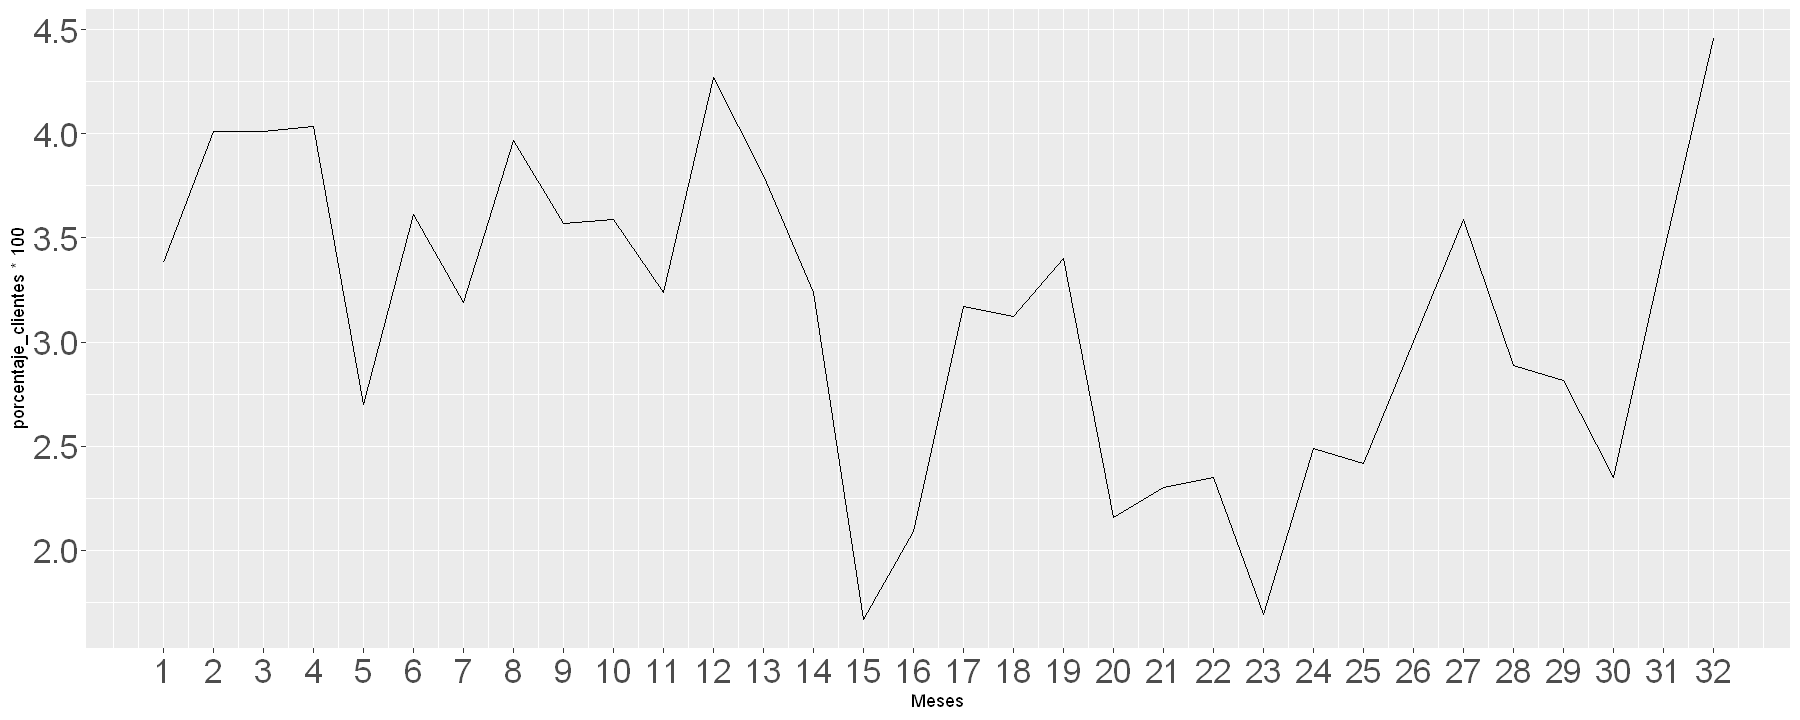

: 

In [ ]:

#head(dataset)

library(dplyr)
library(ggplot2)


listado_clientes_baja = dataset %>% 
    select(numero_de_cliente, clase_ternaria) %>% 
    filter(clase_ternaria == "BAJA+2" | clase_ternaria == "BAJA+1") %>% 
    distinct(numero_de_cliente)


ventana_tiempo_bajas = 
  inner_join(dataset, listado_clientes_baja, by = "numero_de_cliente") %>% 
  group_by(numero_de_cliente) %>% 
  summarise(
    cantidad_meses = n_distinct(foto_mes),
    .groups = "drop"
)

n <- n_distinct(ventana_tiempo_bajas$numero_de_cliente)

porcentaje_meses = ventana_tiempo_bajas %>%
    group_by(cantidad_meses) %>% 
    summarise(
        porcentaje_clientes = n_distinct(numero_de_cliente)/n ,
        .groups = "drop"
    )   

ventana_tiempo_bajas %>%
  summarise(
    min              = min(cantidad_meses),
    Q1               = quantile(cantidad_meses, 0.25),
    media            = mean(cantidad_meses),
    mediana          = median(cantidad_meses),
    Q3               = quantile(cantidad_meses, 0.75),
    max              = max(cantidad_meses),
    desviacion       = sd(cantidad_meses),
    coef_var         = sd(cantidad_meses) / mean(cantidad_meses),
    MAD_normalizado  = mad(cantidad_meses),
    trim_mean_10     = mean(cantidad_meses, trim = 0.10),
    trim_mean_20     = mean(cantidad_meses, trim = 0.20)
  )

options(repr.plot.width = 15, repr.plot.height = 6) 

ggplot(porcentaje_meses, aes(x=cantidad_meses, y=porcentaje_clientes*100)) +
  geom_line() +
  theme(axis.text.x = element_text(size = 20)) +
  theme(axis.text.y = element_text(size = 20)) +
  scale_x_continuous("Meses", labels = as.character(porcentaje_meses$cantidad_meses), breaks = porcentaje_meses$cantidad_meses)

#Extraigo columnas mas relevantes de la corrida inicial con 100 iter
importancia_variables <- read.delim(
  "../../repos/labo2025v/src/workflows/Archivos/exp_WF9101_impo.txt",
  sep = "\t",
  header = TRUE,
  stringsAsFactors = FALSE
)


In [ ]:
# Feature Engineering Historico

# todo es lagueable, menos la primary key y la clase
cols_lagueables <- copy( setdiff(
    colnames(dataset),
    c("numero_de_cliente", "foto_mes", "clase_ternaria")
) )

cols_promedio <- copy( setdiff(
    colnames(dataset),
    c("numero_de_cliente", "foto_mes", "clase_ternaria","cliente_edad", "cliente_antiguedad", "internet", "cdescubierto_preacordado", "thomebanking",
     "Master_fultimo_cierre", "Master_fechaalta", "Master_status", "Visa_status", "Visa_fultimo_cierre", "Visa_fechaalta")
) )

# https://rdrr.io/cran/data.table/man/shift.html

# lags de orden 1
dataset[,
    paste0(cols_lagueables, "_lag1") := shift(.SD, 1, NA, "lag"),
    by = numero_de_cliente,
    .SDcols = cols_lagueables
]

# lags de orden 2
dataset[,
    paste0(cols_lagueables, "_lag2") := shift(.SD, 2, NA, "lag"),
    by = numero_de_cliente,
    .SDcols = cols_lagueables
]

# Cambio los delta lags por ratios
for (vcol in cols_lagueables)
{
    lag1 <- paste0(vcol, "_lag1")
    lag2 <- paste0(vcol, "_lag2")
    
    # Ratio vs lag1
    dataset[, paste0(vcol, "_ratio1") :=
        fifelse(get(lag1) == 0 | is.na(get(lag1)),
                NA_real_,
                get(vcol) / get(lag1) - 1)]

    # Ratio vs lag2
    dataset[, paste0(vcol, "_ratio2") :=
        fifelse(get(lag2) == 0 | is.na(get(lag2)),
                NA_real_,
                get(vcol) / get(lag2) - 1)]
}


# Promedio movil 
setorder(dataset, numero_de_cliente, foto_mes)



#Para 6 meses
dataset[, paste0(cols_promedio, "_ma12") :=
          lapply(.SD, function(x) frollmean(x, n = 12, align = "right", fill = NA)),
        by = numero_de_cliente,
        .SDcols = cols_promedio]

#Para 12 meses
dataset[, paste0(cols_promedio, "_ma6") :=
          lapply(.SD, function(x) frollmean(x, n = 6, align = "right", fill = NA)),
        by = numero_de_cliente,
        .SDcols = cols_promedio]

# creo ratio ult 12 meses vs 6 meses
for (vcol in cols_promedio)
{
    ma6 <- paste0(vcol, "_ma6")
    ma12 <- paste0(vcol, "_ma12")
    
    # ma6 vs ma12
    dataset[, paste0(vcol, "_ratio_m6_m12") :=
        fifelse(get(ma12) == 0 | is.na(get(ma12)),
                NA_real_,
                get(ma6) / get(ma12) - 1)]

}



Verificacion de los campos recien creados

In [ ]:
ncol(dataset)
colnames(dataset)
head(dataset)

[1] 2253

[1] "numero_de_cliente"                        
   [2] "foto_mes"                                 
   [3] "internet"                                 
   [4] "cliente_edad"                             
   [5] "cliente_antiguedad"                       
   [6] "mrentabilidad"                            
   [7] "mrentabilidad_annual"                     
   [8] "mcomisiones"                              
   [9] "mactivos_margen"                          
  [10] "mpasivos_margen"                          
  [11] "cproductos"                               
  [12] "mcuenta_corriente"                        
  [13] "mcaja_ahorro"                             
  [14] "cdescubierto_preacordado"                 
  [15] "mcuentas_saldo"                           
  [16] "ctarjeta_visa"                            
  [17] "ctarjeta_visa_transacciones"              
  [18] "mtarjeta_visa_consumo"                    
  [19] "ctarjeta_master"                          
  [20] "ctarjeta_master_transacciones"            
  [21] "mtarjeta_master_consumo"                  
  [22] "cprestamos_personales"                    
  [23] "mprestamos_personales"                    
  [24] "cpayroll_trx"                             
  [25] "mpayroll"                                 
  [26] "mttarjeta_visa_debitos_automaticos"       
  [27] "ccomisiones_mantenimiento"                
  [28] "mcomisiones_mantenimiento"                
  [29] "ccomisiones_otras"                        
  [30] "mtransferencias_recibidas"                
  [31] "ccallcenter_transacciones"                
  [32] "thomebanking"                             
  [33] "chomebanking_transacciones"               
  [34] "ctrx_quarter"                             
  [35] "Master_status"                            
  [36] "Master_mfinanciacion_limite"              
  [37] "Master_Fvencimiento"                      
  [38] "Master_msaldototal"                       
  [39] "Master_mlimitecompra"                     
  [40] "Master_fultimo_cierre"                    
  [41] "Master_fechaalta"                         
  [42] "Master_mconsumototal"                     
  [43] "Master_cconsumos"                         
  [44] "Master_mpagominimo"                       
  [45] "Visa_status"                              
  [46] "Visa_mfinanciacion_limite"                
  [47] "Visa_Fvencimiento"                        
  [48] "Visa_msaldototal"                         
  [49] "Visa_mlimitecompra"                       
  [50] "Visa_fultimo_cierre"                      
  [51] "Visa_fechaalta"                           
  [52] "Visa_mconsumototal"                       
  [53] "Visa_cconsumos"                           
  [54] "Visa_mpagominimo"                         
  [55] "clase_ternaria"                           
  [56] "kmes"                                     
  [57] "mpayroll_sobre_edad"                      
  [58] "entrenamiento"                            
  [59] "rf_001_006"                               
  [60] "rf_001_008"                               
  [61] "rf_001_007"                               
  [62] "rf_001_015"                               
  [63] "rf_001_001"                               
  [64] "rf_001_012"                               
  [65] "rf_001_000"                               
  [66] "rf_001_010"                               
  [67] "rf_001_011"                               
  [68] "rf_001_003"                               
  [69] "rf_001_009"                               
  [70] "rf_001_014"                               
  [71] "rf_001_005"                               
  [72] "rf_001_002"                               
  [73] "rf_001_013"                               
  [74] "rf_001_004"                               
  [75] "rf_002_009"                               
  [76] "rf_002_014"                               
  [77] "rf_002_002"                               
  [78] "rf_002_010"                               
  [79] "rf_002_006"      

numero_de_cliente,foto_mes,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,⋯,rf_020_013_delta1,rf_020_013_delta2,rf_020_015_delta1,rf_020_015_delta2,rf_020_009_delta1,rf_020_009_delta2,rf_020_004_delta1,rf_020_004_delta2,rf_020_011_delta1,rf_020_011_delta2
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
29186441,202003,1,61,280,2611.543,52214.18,2047.790,-187.5891,668.1990,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
29186441,202004,1,61,281,2758.701,52436.41,2022.469,-261.4220,889.0660,⋯,0,NA,0,NA,0,NA,0,NA,0,NA
29186441,202005,1,61,282,2853.880,53033.33,2038.534,-168.4741,863.5782,⋯,0,0,0,0,0,0,0,0,0,0
29186441,202006,NA,61,283,NA,NA,NA,NA,NA,⋯,NA,NA,0,0,0,0,0,0,0,0
29186441,202007,1,61,284,3052.337,53831.51,1970.036,-217.1336,1139.8112,⋯,NA,0,0,0,0,0,0,0,0,0
29186441,202008,1,61,285,4120.270,55020.54,1921.690,-228.3395,2102.6622,⋯,0,NA,0,0,0,0,0,0,0,0


#### 9.3.1.6  FEhist Reduccion dimensionalidad con canaritos

Esta etapa solo se mostrará a la *modalidad Anlista Sr* por algun canal secreto de forma de no confundir a los *Analista Jr*  nni distraer con detalles operativos a la estratégica *Modalidad Gerencial*

In [ ]:
# No se implementa la reduccion de la dimensionalidad con canaritos

### 9.3.2 Modelado

#### 9.3.2.1 Training Strategy

Se hace una estrategia de entrenamiento muy sencilla, tomando todos los meses posibles, SIN eliminar nada x pandemia ni por ningun otro motivo

* future = 202109  obviamente completo

* final_train =  [ 201901, 202107 ]  SIN undersampling

* training
   * testing = NO HAY
   * validation =  202107   completo, sin undersampling
   * training = [ 201901, 202105 ]  donde se consideran el 100% de los CONTINUA

In [ ]:
PARAM$trainingstrategy$validate <- c(202107)

PARAM$trainingstrategy$training <- c(
  201901, 201902, 201903, 201904, 201905, 201906,
  201907, 201908, 201909, 201910, 201911, 201912,
  202001, 202002, 202003, 202004, 202005, 202006,
  202007, 202008, 202009, 202010, 202011, 202012,
  202101, 202102, 202103, 202104, 202105
)


PARAM$trainingstrategy$training_pct <- 1.0


PARAM$trainingstrategy$positivos <- c( "BAJA+1", "BAJA+2")

In [ ]:
# seteo la clase01   1={BAJA+1, BAJA+2}   0={CONTINUA}
dataset[, clase01 := ifelse( clase_ternaria %in% PARAM$trainingstrategy$positivos, 1, 0 )]

In [ ]:
# los campos en los que se entrena
campos_buenos <- copy( setdiff(
    colnames(dataset), c("clase_ternaria","clase01","azar"))
)

In [ ]:
# preparo para que se puede hacer undersampling de los CONTINUA
#  solamente por un tema de VELOCIDAD
set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset[, azar:=runif(nrow(dataset))]

# undersampling de los CONTINUA
dataset[, fold_train :=  foto_mes %in%  PARAM$trainingstrategy$training &
    (clase_ternaria %in% c("BAJA+1", "BAJA+2") |
     azar < PARAM$trainingstrategy$training_pct ) ]


if( !require("lightgbm")) install.packages("lightgbm")
require("lightgbm")

dtrain <- lgb.Dataset(
  data= data.matrix(dataset[fold_train == TRUE, campos_buenos, with = FALSE]),
  label= dataset[fold_train == TRUE, clase01],
  free_raw_data= TRUE
)

In [ ]:
# datos de validation
dvalidate <- lgb.Dataset(
  data= data.matrix(dataset[foto_mes %in% PARAM$trainingstrategy$validate, campos_buenos, with = FALSE]),
  label= dataset[foto_mes %in% PARAM$trainingstrategy$validate, clase01],
  free_raw_data= TRUE
)

nrow(dvalidate)

[1] 33053

####  9.3.2.2. Hyperparameter Tuning

* Clase binaria que se optimiza :  positivos = [ BAJA+1, BAJA+2 ]

* Metrica que se optimiza **AUC** Area Under Curve de la  ROC Curve

es muy importante notar que intencionalmente  **NO** se está optimizando la funcion de ganancia del problema

* Cantidad de iteraciones inteligentes de la Optimizacion Bayesiana = **10**

* Parametros no default, fijos de LightGBM que no se optimizan
  * max_bin = 31 , Alienigenas Ancestrales contruyeron las pirámides y dejaron a la humanidad en un jeroglifico  *max_bin=31*
  * feature_fraction = 0.5  para poner algo que generalmente no falla
  * learning_rate = 0.03  para que aprenda lento


* Parametros que se optimizan en la Bayesian Optimization
  * num_leaves  [8, 256]
  * min_data_in_leaf  [8, 8192]

In [ ]:
# paquetes necesarios para la Bayesian Optimization
if(!require("DiceKriging")) install.packages("DiceKriging")
require("DiceKriging")

if(!require("mlrMBO")) install.packages("mlrMBO")
require("mlrMBO")

Cargando paquete requerido: DiceKriging

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"no hay paquete llamado 'DiceKriging'"
Installing package into 'C:/Users/ornec/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'DiceKriging' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ornec\AppData\Local\Temp\RtmpKozWsa\downloaded_packages


Cargando paquete requerido: DiceKriging

Warning message:
"package 'DiceKriging' was built under R version 4.5.2"
Cargando paquete requerido: mlrMBO

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"no hay paquete llamado 'mlrMBO'"
Installing package into 'C:/Users/ornec/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)

also installing the dependencies 'XML', 'fastmatch', 'RcppArmadillo', 'mlr', 'ParamHelpers', 'smoof', 'BBmisc', 'checkmate', 'lhs', 'parallelMap'




package 'XML' successfully unpacked and MD5 sums checked
package 'fastmatch' successfully unpacked and MD5 sums checked
package 'RcppArmadillo' successfully unpacked and MD5 sums checked
package 'mlr' successfully unpacked and MD5 sums checked
package 'ParamHelpers' successfully unpacked and MD5 sums checked
package 'smoof' successfully unpacked and MD5 sums checked
package 'BBmisc' successfully unpacked and MD5 sums checked
package 'checkmate' successfully unpacked and MD5 sums checked
package 'lhs' successfully unpacked and MD5 sums checked
package 'parallelMap' successfully unpacked and MD5 sums checked
package 'mlrMBO' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\ornec\AppData\Local\Temp\RtmpKozWsa\downloaded_packages


Cargando paquete requerido: mlrMBO

Warning message:
"package 'mlrMBO' was built under R version 4.5.2"
Cargando paquete requerido: mlr

Warning message:
"package 'mlr' was built under R version 4.5.2"
Cargando paquete requerido: ParamHelpers

Warning message:
"package 'ParamHelpers' was built under R version 4.5.2"

Adjuntando el paquete: 'ParamHelpers'


The following object is masked from 'package:R.utils':

    isVector



Adjuntando el paquete: 'mlr'


The following objects are masked from 'package:R.utils':

    resample, setThreshold


Cargando paquete requerido: smoof

Warning message:
"package 'smoof' was built under R version 4.5.2"
Cargando paquete requerido: checkmate

Warning message:
"package 'checkmate' was built under R version 4.5.2"

Adjuntando el paquete: 'checkmate'


The following object is masked from 'package:DiceKriging':

    checkNames


The following object is masked from 'package:R.utils':

    asInt



Adjuntando el paquete: 'smoof'


The following objects 

Definición de la Bayesian Optimization
<br> Si se desea optimizar un hiperparámetro que esta como fijo, debe QUITARSE de param_fijos y agregarse a PARAM$hipeparametertuning$hs

In [ ]:
# un Analista Jr  debe poder animarse a hacer 100 iteraciones
PARAM$hipeparametertuning$num_interations <- 20

# parametros fijos del LightGBM
PARAM$lgbm$param_fijos <- list(
  objective= "binary",
  metric= "auc",
  first_metric_only= TRUE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  verbosity= -100,
  force_row_wise= TRUE, # para evitar warning
  seed= PARAM$semilla_primigenia,
  max_bin= 31,

  num_iterations= 9999,  # valor grande, lo limita early_stopping_rounds
  early_stopping_rounds= 400
)

PARAM$hipeparametertuning$hs <- makeParamSet(
  makeIntegerParam("num_leaves", lower= 2L, upper= 256L),
  makeIntegerParam("min_data_in_leaf", lower= 2L, upper= 8192L),
  makeNumericParam("feature_fraction", lower= 0.1, upper= 0.9),
  makeNumericParam("learning_rate", lower= 0.01, upper= 0.5)
)

Función "señora caja negra"  que es llamada para verificar la realidad por la Bayesian Optimization

In [ ]:
# En  x llegan los parmaetros de la bayesiana
#  devuelve la AUC en validate del modelo entrenado
#  en el parametro x llegan los hiperparámetros que se estan optimizando

EstimarGanancia_AUC_lightgbm <- function(x) {

  # x pisa (o agrega) a param_fijos
  param_completo <- modifyList(PARAM$lgbm$param_fijos, x)

  # entreno LightGBM
  modelo_train <- lgb.train(
    data= dtrain,
    valids= list(valid = dvalidate),
    eval= "auc",
    param= param_completo,
    verbose= -100
  )

  # recupero la AUC en validation
  AUC <- modelo_train$record_evals$valid$auc$eval[[modelo_train$best_iter]]

  # esta es la forma de devolver un parametro extra
  attr(AUC, "extras") <- list("num_iterations"= modelo_train$best_iter)

  # hago espacio en la memoria
  rm(modelo_train)
  gc(full= TRUE, verbose= FALSE)

  message(format(Sys.time(), "%a %b %d %X %Y"), " AUC ", AUC)

  return(AUC)
}

seteo de la Bayesian Optimization (complejo)
<br> copiado y pegado de la documentación de la librería

In [ ]:
configureMlr(show.learner.output = FALSE)

# configuro la busqueda bayesiana,  los hiperparametros que se van a optimizar
# por favor, no desesperarse por lo complejo
obj.fun <- makeSingleObjectiveFunction(
    fn= EstimarGanancia_AUC_lightgbm, # la funcion que voy a maximizar
    minimize= FALSE, # estoy Maximizando AUC
    noisy= FALSE,
    par.set= PARAM$hipeparametertuning$hs,
    has.simple.signature= FALSE # paso los parametros en una lista
)

# cada 600 segundos guardo el resultado intermedio
ctrl <- makeMBOControl(
    save.on.disk.at.time= 600,
    save.file.path= "HT.RDATA"
)

# indico la cantidad de iteraciones que va a tener la Bayesian Optimization
ctrl <- setMBOControlTermination(
    ctrl,
    iters= PARAM$hipeparametertuning$num_interations  # cantidad de iteraciones inteligentes
)

# defino el método estandar para la creacion de los puntos iniciales
#   los "No Inteligentes"
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())

# mas configuraciones
surr.km <- makeLearner(
    "regr.km",
    predict.type= "se",
    covtype= "matern3_2",
    control= list(trace = TRUE)
)

: 

Corrida de la Bayesian Optimization,  aqui se hace el trabajo pesado
<br> por favor no se asuste con los warnings que pudieran aparecer

Si corrío a medias y llegó a las iteraciones inteligentes, en el archivo binario HT.RDATA quedó lo ya procesado y es utilizado para retomar la corrida desde lo último que llegó a grabar.

In [ ]:
# inicio la optimizacion bayesiana

if (!file.exists("HT.RDATA")) {
  bayesiana_salida <- mbo(obj.fun, learner= surr.km, control= ctrl)
} else {
  bayesiana_salida <- mboContinue("HT.RDATA") # retomo en caso que ya exista
}

Computing y column(s) for design. Not provided.



la bayesian optimization ha corrido, extraigo los mejores hiperparametros

In [ ]:
# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y, -num_iterations)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file="BO_log.txt",
  sep="\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  setdiff(colnames(tb_bayesiana),
    c("y","dob","eol","error.message","exec.time","ei","error.model",
      "train.time","prop.type","propose.time","se","mean","iter")),
  with= FALSE
]

print(PARAM$out$lgbm$mejores_hiperparametros)

### 9.3.3 Produccion

#### Final Training
Construyo el modelo final, que es uno solo, no hace ningun tipo de particion < training, validation, testing>]

##### Final Training Dataset

Aqui esta la gran decision de en qué meses hago el Final Training
<br> debo utilizar los mejores hiperparámetros que encontré en la optimización bayesiana

In [ ]:
PARAM$trainingstrategy$final_train <- c(
  201901, 201902, 201903, 201904, 201905, 201906,
  201907, 201908, 201909, 201910, 201911, 201912,
  202001, 202002, 202003, 202004, 202005, 202006,
  202007, 202008, 202009, 202010, 202011, 202012,
  202101, 202102, 202103, 202104, 202105, 202106,
  202107
)


dataset[, fold_final_train := foto_mes %in% PARAM$trainingstrategy$final_train ]

# creo el dfinal_train en formato  LightGBM
dfinal_train <- lgb.Dataset(
  data= data.matrix(dataset[fold_final_train == TRUE, campos_buenos, with= FALSE]),
  label= dataset[fold_final_train == TRUE, clase01],
  free_raw_data= TRUE
)

nrow( dfinal_train) # verifico el tamaño

##### Final Training Hyperparameters

In [ ]:
# uno los parametros fijos y los mejores encontrados de los variables
fijos <- copy(PARAM$lgbm$param_fijos)

# quito lo que optimice en la Bayesian Optimization
fijos$num_iterations <- NULL
fijos$early_stopping_rounds <- NULL

# agrego a los hiperparametros fijos los que encontre con la Bayesian Optimization
param_final <- c(fijos, PARAM$out$lgbm$mejores_hiperparametros)

##### Training
Genero el modelo final, siempre sobre TODOS los datos de  final_train, sin hacer ningun tipo de undersampling de la clase mayoritaria

In [ ]:
final_model <- lgb.train(
  data= dfinal_train,
  param= param_final,
  verbose= -100
)

In [ ]:
# grabo a disco el modelo en un formato para seres humanos ... ponele ...

lgb.save(final_model, "modelo.txt")

In [ ]:
# ahora imprimo la importancia de variables

tb_importancia <- as.data.table(lgb.importance(final_model))
archivo_importancia <- "impo.txt"

fwrite( tb_importancia,
  file= archivo_importancia,
  sep= "\t"
)

#### Scoring

Aplico el modelo final a los datos del futuro

In [ ]:
PARAM$trainingstrategy$future <- c(202109)

dfuture <- dataset[ foto_mes %in% PARAM$trainingstrategy$future ]

In [ ]:
# aplico final_model   a dfuture

prediccion <- predict(
  final_model,
  data.matrix(dfuture[, campos_buenos, with= FALSE])
)

##### Tabla Prediccion

In [ ]:
tb_prediccion <- dfuture[, list(numero_de_cliente)]
tb_prediccion[, prob := prediccion]

# grabo las probabilidad del modelo
#  me va a ser util para hacer Ensembles de modelos
fwrite(tb_prediccion,
  file= "prediccion.txt",
  sep= "\t"
)

#### Kaggle Competition Submit

Genero las salidas y hago los submits a Kaggle

In [ ]:
# genero archivos con los  "envios" mejores
# suba TODOS los archivos a Kaggle

PARAM$kaggle$competencia <- "labol-2025-virtual-analista-jr"
PARAM$kaggle$cortes <- seq(1800, 2400, by = 100)

# ordeno por probabilidad descendente
setorder(tb_prediccion, -prob)

dir.create("kaggle")

for (envios in PARAM$kaggle$cortes) {

  tb_prediccion[, Predicted := 0L] # seteo inicial a 0
  tb_prediccion[1:envios, Predicted := 1L] # marclo los primeros

  archivo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_", envios, ".csv")

  # grabo el archivo
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
    file= archivo_kaggle,
    sep= ","
  )

  # subida a Kaggle, armo la linea de comando
  comando <- "kaggle competitions submit"
  competencia <- paste("-c", PARAM$kaggle$competencia)
  arch <- paste( "-f", archivo_kaggle)

  mensaje <- paste0("-m 'envios=", envios,
  "  semilla=", PARAM$semilla_primigenia,
    "'" )

  linea <- paste( comando, competencia, arch, mensaje)

  salida <- system(linea, intern=TRUE) # el submit a Kaggle
  cat(salida, "\n")
}

In [ ]:
# grabo los parametros
if( !require("yaml")) install.packages("yaml")
require("yaml")

write_yaml( PARAM, file="PARAM.yml")

In [ ]:
format(Sys.time(), "%a %b %d %X %Y")